## Imports

In [1]:
# standard python libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import metrics
from IPython.display import display_html
from inspect import signature

# spark and pyspark.sql libs
import ibmos2spark
from project_lib import Project
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql import types as t

# pyspark.ml libs
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier, NaiveBayes, DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, OneHotEncoderEstimator, MinMaxScaler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190610190352-0000
KERNEL_ID = 0c4fdc2f-5a9f-4fc6-8a63-334ec8f786a5


## Settings

In [2]:
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = 8, 6

## Set up cluster and read in dataset

In [3]:
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-831012fc-ab47-4233-9f51-132a56d7e2d3',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': '38qBg0jvppqN8J6KhN_x8feM8dQD7M4qBGEDJ8A_c2co'
}

configuration_name = 'os_dee56333f8fe430da6b3713c9464da54_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-9rd2ra6j6vxxcf'))
df.take(3)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [4]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(spark.sparkContext, 'dda0375a-6dbd-4640-a68c-e80389159369', 'p-14d8e5f9ff3224993e6ca5a5283f1cdf5e03d434')
pc = project.project_context

## Clean dataset

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



#### Dates
Convert long format to timestamps

In [6]:
convert_to_timestamp = f.udf(lambda x: f.from_unixtime(x/1000), t.TimestampType())

df = df.withColumn("dateTime", f.from_unixtime(df["ts"]/1000))
df = df.withColumn("registrationDate", f.from_unixtime(df["registration"]/1000))
df.select('dateTime', 'registrationDate').agg(f.min('dateTime'), f.max('dateTime'), f.min('registrationDate'), f.max('registrationDate')).show()

+-------------------+-------------------+---------------------+---------------------+
|      min(dateTime)|      max(dateTime)|min(registrationDate)|max(registrationDate)|
+-------------------+-------------------+---------------------+---------------------+
|2018-10-01 00:00:11|2018-12-01 00:01:06|  2017-11-05 03:56:33|  2018-11-24 15:37:54|
+-------------------+-------------------+---------------------+---------------------+



#### Filter out non-logged in users
Filter out guests and logged out users, as they have no ID to link activity to (though we can use sessionId to link logged out users, this is generally not considered ethical and possibly illegal)

In [7]:
df = df.filter(df["auth"].isin(["Logged In", 'Cancelled']))

#### Parse technical details and location data

Some of the input columns has mixed data that is too detailed for our use case. Instead, we'll parse out less detailed information and use these as separate features, e.g. "device" and "state".

In [8]:
tech_variables = f.split(df['userAgent'], ' ')
df = df.withColumn('browser', f.translate(f.split(tech_variables[0], '/')[0], '"',''))
df = df.withColumn('device', f.translate(f.split(tech_variables[1], '\(')[1], ';', ''))

df = df.withColumn('state', f.split(df['location'], ',')[1])

#### Add churn variable


We'll define churn as the point in time when the user cancels his/her service with us.

In [9]:
df = df.withColumn("churn", f.when(df["auth"]=='Cancelled', 1).otherwise(0) )

#### Exclude post-churn events
Filter out data to only include non-churned users or activity up until churn event

In [10]:
has_churned = df.select('userId', 'churn').groupBy('userId').agg(f.max('churn').alias('hasChurned'))
churn_ts = df.filter(df['churn']==1).select('userId', 'dateTime').groupBy('userId').agg(f.min('dateTime').alias('churnTs'))

df = df.join(churn_ts, ['userId'], how='left').join(has_churned, ['userId'], how='left')
df = df.filter( (df['hasChurned']==0) | (df['dateTime']<df['churnTs']) )

#### Page visits
Count how many times each user has visited each page. Note that we exclude pages related to cancellation, i.e. variables related to the target event

In [11]:
pages_to_exclude = ['Cancel', 'Cancellation Confirmation']
page_visits = df.filter(~df.page.isin(pages_to_exclude)).groupBy('userId').pivot('page').count().fillna(0)

#### Derive user attributes

Derive attributes related to the user (i.e., not to individual actions). Due to Spark's limitations in terms of udfs this is not easily solved through functions, hence the breaking of DRY-principles.

In [12]:
#most_common_value = f.udf(lambda col: df.groupby("userId", col)
#        .count()
#        .withColumn("count_"+col, f.array("count", col))
#        .groupby("userId")
#        .agg(f.max("count_"+col).getItem(1).alias(col)), t.StringType())
#
#most_common_value('gender')

In [13]:
device = (
    df.groupby("userId", "device").count()
    .withColumn("count_device", f.array("count", "device"))
    .groupby("userId").agg(f.max("count_device").getItem(1).alias("most_common_device"))
)

browser = (
    df.groupby("userId", "browser").count()
    .withColumn("count_browser", f.array("count", "browser"))
    .groupby("userId").agg(f.max("count_browser").getItem(1).alias("most_common_browser"))
)

state = (
    df.groupby("userId", "state").count()
    .withColumn("count_state", f.array("count", "state"))
    .groupby("userId").agg(f.max("count_state").getItem(1).alias("most_common_state"))
)

gender = (
    df.groupby("userId", "gender").count()
    .withColumn("count_gender", f.array("count", "gender"))
    .groupby("userId").agg(f.max("count_gender").getItem(1).alias("gender"))
) 

user_stats = device.join(browser, ['userId'], how='left').join(gender, ['userId'], how='left').join(state, ['userId'], how='left')

#### Calculate activity statistics

In [14]:
# Calculate statistics on song listens
plays = df.filter(df['page']=='NextSong').groupBy('userId', 'sessionId').agg(f.count('page').alias('plays')).groupBy('userId').agg(f.avg('plays').alias('avgPlays'), f.max('plays').alias('maxPlays'))
# Calculate general activity statistics
activity = df.groupBy('userId').agg(((f.max('ts')-f.min('registration'))/1000).alias('timeSinceRegistration'), f.max("itemInSession").alias('maxItems'), f.countDistinct("sessionId").alias('sessionsCount'))

In [15]:
# Calculate session duration statistics
_length = f.udf(lambda x: max(x)-min(x), t.LongType())

session_duration = df.groupby(['userId','sessionId']).agg(f.collect_list('ts').alias('ts'))
session_duration = session_duration.withColumn('duration', _length('ts')/1000)
session_duration = session_duration.select(['userId','sessionId','duration'])
session_duration = session_duration.groupby('userId').agg(f.avg('duration').alias('avg_session_duration'), f.max('duration').alias('max_session_duration'))

#### Join datasets and convert to pandas

In [16]:
dfa = user_stats.join(session_duration, ['userId'], how='left').join(plays, ['userId'], how='left').join(activity, ['userId'], how='left').join(page_visits, ['userId'], how='left').join(has_churned, ['userId'], how='left')
dfp = dfa.toPandas()
dfp.head()

,userId,most_common_device,most_common_browser,gender,most_common_state,avg_session_duration,max_session_duration,avgPlays,maxPlays,timeSinceRegistration,...,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,hasChurned
0,100010,iPhone,Mozilla,F,CT,12616.000000,13354.0,48.000000,49,1237965.0,...,96,22,0,0,0,0,3,4,2,1
1,200002,iPhone,Mozilla,M,IL-IN-WI,15782.600000,27244.0,62.000000,105,4607115.0,...,310,11,0,2,0,1,5,15,2,1
2,296,Macintosh,Mozilla,F,PA-NJ,5780.200000,14783.0,22.400000,55,2301336.0,...,112,9,0,1,0,1,0,8,1,1
3,125,Macintosh,Mozilla,M,TX,5099.000000,12965.0,20.666667,53,9108471.0,...,62,6,0,3,0,0,1,3,0,0
4,124,Macintosh,Mozilla,F,NJ,26738.823529,76852.0,114.125000,313,9724627.0,...,1826,1,3,15,0,0,15,102,0,1


#### Save cleaned and aggregated dataframe

In [17]:
project.save_data(data=dfp.to_csv(index=False), file_name='aggregated-sparkify-event-data.csv', overwrite=True)

{'file_name': 'aggregated-sparkify-event-data.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'sparkify-donotdelete-pr-9rd2ra6j6vxxcf',
 'asset_id': '801b3ab6-461c-4456-a96b-4259f0884840'}

## Exploration

In [18]:
#dfa = spark.read.format("csv").option("header", "true").load(cos.url('aggregated-sparkify-event-data.csv', 'sparkify-donotdelete-pr-9rd2ra6j6vxxcf'))
#dfp = dfa.toPandas()
#dfp.loc[:, 'avg_session_duration':'timeSinceRegistration'] = dfp.loc[:, 'avg_session_duration':'timeSinceRegistration'].astype(float)
#dfp.loc[:, 'maxItems':] = dfp.loc[:, 'maxItems':].astype(int)
#dfp.head()

In [ ]:
dfp.describe(include=['O'])

,userId,most_common_device,most_common_browser,gender,most_common_state
count,448,448,448,448,448
unique,448,6,1,2,70
top,299,Windows,Mozilla,M,CA
freq,1,209,448,250,62


In [ ]:
dfp.describe(include=[np.number])

,avg_session_duration,max_session_duration,avgPlays,maxPlays,timeSinceRegistration,maxItems,sessionsCount,About,Add Friend,Add to Playlist,...,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,hasChurned
count,448.000000,448.000000,448.000000,448.000000,4.480000e+02,448.000000,448.000000,448.000000,448.000000,448.000000,...,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000
mean,16064.770961,53662.406250,65.611684,212.660714,7.156692e+06,261.629464,13.571429,2.290179,18.051339,27.564732,...,966.243304,17.350446,1.305804,6.616071,0.261161,0.640625,10.962054,53.183036,2.160714,0.220982
std,9861.300134,40045.209729,39.494966,158.480497,3.503158e+06,188.396569,13.171024,3.151746,22.203443,33.678242,...,1150.827764,21.400829,1.805476,7.894149,0.536048,0.709697,13.356609,69.652108,2.542009,0.415372
min,790.000000,790.000000,1.000000,1.000000,-4.517400e+04,6.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8222.875000,21050.250000,33.916667,81.750000,5.255540e+06,107.000000,5.000000,0.000000,3.000000,5.000000,...,187.750000,3.000000,0.000000,1.000000,0.000000,0.000000,2.000000,9.000000,0.000000,0.000000
50%,14747.104167,45784.500000,61.092857,184.000000,6.572030e+06,226.000000,9.000000,1.000000,10.000000,16.000000,...,550.000000,10.000000,1.000000,4.000000,0.000000,1.000000,6.000000,28.000000,1.000000,0.000000
75%,21761.381300,79516.500000,89.210000,314.500000,8.597003e+06,391.250000,18.000000,3.000000,24.000000,37.250000,...,1275.000000,26.250000,2.000000,9.000000,0.000000,1.000000,15.250000,76.250000,3.000000,0.000000
max,90129.000000,206766.000000,360.000000,810.000000,3.372363e+07,1005.000000,92.000000,20.000000,158.000000,248.000000,...,8177.000000,187.000000,9.000000,48.000000,3.000000,3.000000,80.000000,506.000000,16.000000,1.000000


,gender,hasChurned,users
0,F,0,153
1,F,1,45
2,M,0,196
3,M,1,54


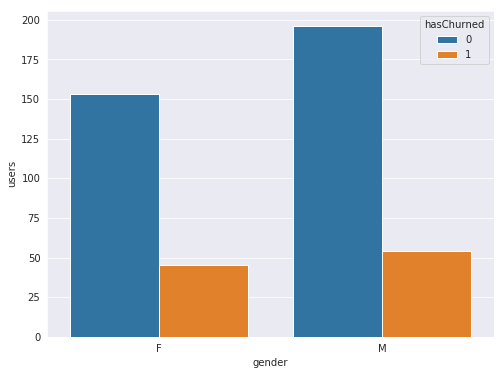

In [ ]:
gender = dfp.groupby(['gender', 'hasChurned'])['userId'].count().reset_index().rename(columns={'userId':'users'}) #.plot(x='gender', kind='bar')
sns.barplot(data=gender, x='gender', y ='users', hue='hasChurned');
gender

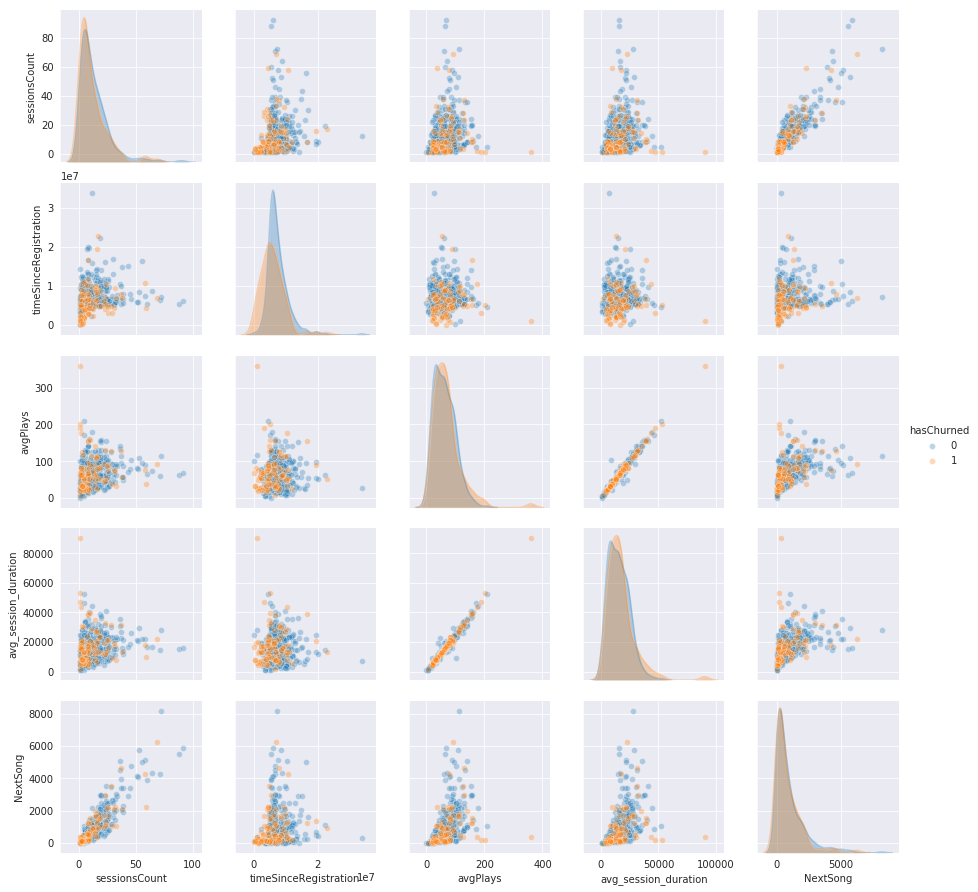

In [ ]:
# Review distribution of and relationship between some candidate variables
cols = ['sessionsCount', 'timeSinceRegistration', 'avgPlays', 'avg_session_duration', 'NextSong']
sns.pairplot(dfp, vars=cols, hue='hasChurned', kind='scatter', diag_kws= {'alpha': 0.3}, plot_kws= {'alpha': 0.3} );

The plot above shows churners having lower frequencies across all metrics, indicating that overall low activity is the most predictive feature of churn. To make use of additional features, we will probably have to "normalize" activity data in some way, e.g. by dividing by sessions, time frame or similar. 

In [ ]:
dfp_norm = dfp.copy()
dfp_norm.loc[:,'About':'Upgrade'] = dfp_norm.loc[:,'About':'Upgrade'].div(dfp['sessionsCount'], axis=0)

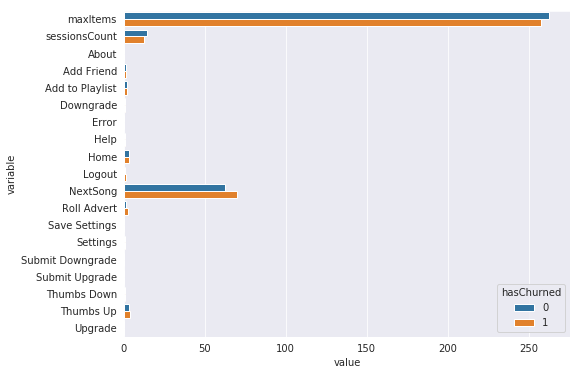

In [ ]:
dfm = dfp_norm.loc[:, 'maxItems':].melt(id_vars=['hasChurned'])
sns.barplot(data=dfm, y='variable', x='value', hue='hasChurned', estimator=np.mean, ci=None)

## Modelling

In [ ]:
results = {}
# try standard and "normalized" datasets
for i, df in enumerate((dfp, dfp_norm)):

    # convert back to spark dataframe
    dfa = spark.createDataFrame(df)

    # split into train and test sets
    train, test = dfa.randomSplit([0.7, 0.3], seed=1337)

    # specify categorical and numerical input variables
    encoding_vars = dfp.select_dtypes(include='O').columns.drop('userId').tolist()
    num_vars = dfp.select_dtypes(include=np.number).columns.drop('hasChurned').tolist()

    # define transformers
    string_indexes = [StringIndexer(inputCol = c, outputCol = 'IDX_' + c, handleInvalid = 'keep') for c in encoding_vars]
    onehot_indexes = [OneHotEncoderEstimator(inputCols = ['IDX_' + c], outputCols = ['OHE_' + c]) for c in encoding_vars]
    label_indexes = StringIndexer(inputCol = 'hasChurned', outputCol = 'label', handleInvalid = 'keep')
    assembler = VectorAssembler(inputCols = num_vars + ['OHE_' + c for c in encoding_vars], outputCol = "features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features") # used to easier interpret coefficients of lr-estimator

    # define candidate estimators
    rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="hasChurned", seed=1337, cacheNodeIds=True)
    lr = LogisticRegression(featuresCol="scaled_features", labelCol="hasChurned")
    gbt = GBTClassifier(featuresCol="scaled_features", labelCol="hasChurned", seed=1337)
    nb = NaiveBayes(featuresCol="scaled_features", labelCol="hasChurned", smoothing=1.0)
    dt = DecisionTreeClassifier(labelCol="scaled_features", featuresCol="hasChurned")

    model_candidates = [lr, rf, gbt]

    # define grid, evaluator and target labels
    paramGrid = ParamGridBuilder().build() 
    evaluator = BinaryClassificationEvaluator(labelCol='hasChurned', metricName='areaUnderROC')
    labels = test.select('hasChurned').toPandas().hasChurned.values

    # try a range of different models
    models = []
    for model in model_candidates:
        # set up pipeline
        pipeline = Pipeline(stages = string_indexes + onehot_indexes + [assembler, scaler, label_indexes, model])
        cv = CrossValidator(estimator=pipeline, 
                       estimatorParamMaps=paramGrid, 
                       evaluator=evaluator,
                       numFolds=3)
        # train model
        model = cv.fit(train)
        models.append(model)
    results[i] = models


In [ ]:
# calculate performance score for each estimator in each input dataset
models_summaries = []
for index in results:
    summary = []
    for i, model in enumerate(results[index]):
        predictions = model.transform(test)
        score = evaluator.evaluate(predictions)
        name = model.bestModel.stages[-1].__dict__['uid'].split('_')[0]
        summary.append({'name':name, 'score':score})
    summary = pd.DataFrame.from_dict(summary).sort_values('score', ascending=False)
    models_summaries.append(summary)

In [161]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
display_side_by_side(models_summaries[0], models_summaries[1])

,name,score
1,RandomForestClassifier,0.569892
0,LogisticRegression,0.557836
2,GBTClassifier,0.507494
,name,score
1,RandomForestClassifier,0.779407
0,LogisticRegression,0.662105
2,GBTClassifier,0.650375


Performance based on the "normalized" dataset seems to be better for all classifiers. Out of the tried ones, random forest does significantly better than the others. Let's see if we can improve on this model further through hyperparameter tuning: 

#### Hyper parameter tuning

In [162]:
paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [3, 4, 5, 6]).addGrid(rf.featureSubsetStrategy, ['auto', 'onethird', 'sqrt']).build() #.addGrid(rf.numTrees, [100]) .addGrid(rf.subsamplingRate, [0.3, 0.7, 1.0])
pipeline = Pipeline(stages = string_indexes + onehot_indexes + [assembler, scaler, label_indexes, rf])
cv = CrossValidator(estimator=pipeline, 
               estimatorParamMaps=paramGrid, 
               evaluator=evaluator,
               numFolds=3)
model = cv.fit(train)
predictions = model.transform(test)
score = evaluator.evaluate(predictions)
score

0.8219289670902575

Trying a range of different parameters could improve the model surprisingly much, more than 0.04! Let's see what the parameters of the final model are:

In [168]:
model.bestModel.stages[-1].extractParamMap()

{Param(parent='RandomForestClassifier_42648e0c4f403076426c', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): True,
 Param(parent='RandomForestClassifier_42648e0c4f403076426c', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_42648e0c4f403076426c', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'onethird',
 Param(parent='RandomForestClassifier_42648e0c4f403076426c', name='featuresCol', doc='features column name'): 'scaled_features',
 Param(pare

#### Model selection

In [163]:
best_model = model.bestModel
rfModel = best_model.stages[-1]
predictions = best_model.transform(test)
prediction_prob = predictions.toPandas()['probability'].str[1]

#### Feature importance

We can investigate what features contribute the most to the prediction by examining the model's feature importance:

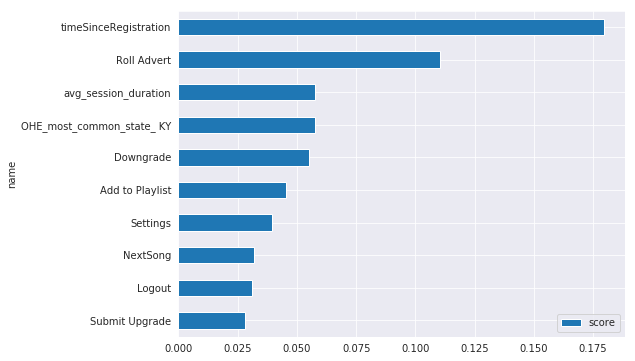

In [165]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

ExtractFeatureImp(rfModel.featureImportances, predictions, "features").head(10).drop('idx', axis=1).plot(kind='barh', x='name').invert_yaxis();

#### AUROC

Let's plot the True Postive Rate and False Positive Rate relationship for different thresholds:

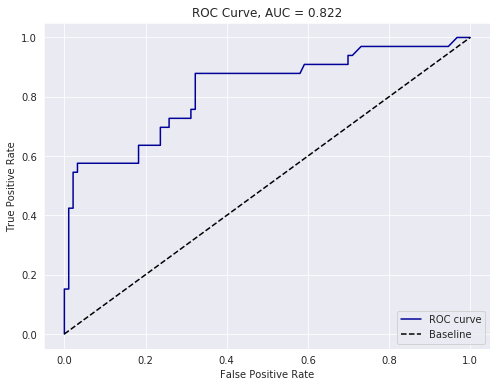

In [166]:
def plot_roc(prediction_prob, labels):
    ''' Plot a receiver operating curve '''
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_prob)
    auc = "%.3f" % metrics.auc(fpr, tpr)
    title = 'ROC Curve, AUC = '+str(auc)
    
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "#000099", label='ROC curve')
    ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    plt.legend(loc='lower right')

plot_roc(prediction_prob, labels)

#### Precision-Recall

Similarly, we plot the Precision/Recall relationship for different thresholds:

,threshold,precision,recall
0,0.110755,0.268293,1.000000
1,0.115314,0.266667,0.969697
2,0.119700,0.268908,0.969697
3,0.119904,0.271186,0.969697
4,0.124384,0.275862,0.969697


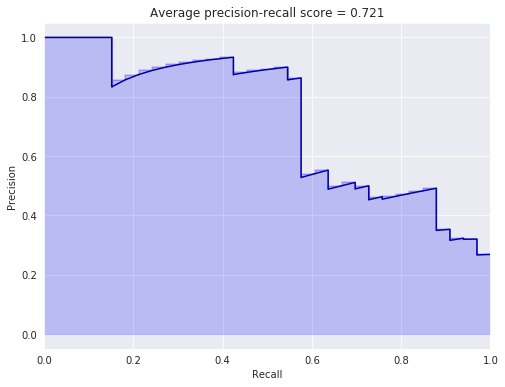

In [167]:
def plot_pr_curver(prediction_prob, labels):
    ''' Plot a receiver operating curve '''
    precision, recall, thresholds = metrics.precision_recall_curve(labels, prediction_prob)
    pr_summary = pd.DataFrame([thresholds, precision, recall]).T
    pr_summary.columns = ['threshold', 'precision', 'recall']
    auc = "%.3f" % metrics.average_precision_score(labels, prediction_prob)
    title = 'Average precision-recall score = '+str(auc)  
    fig, ax = plt.subplots()
    ax.plot(recall, precision, "#000099")
    
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.set_xlim((0,1))
    return pr_summary

pr_summary = plot_pr_curver(prediction_prob, labels)
pr_summary.head()

### Old code

In [58]:
def get_estimator(models, summary, name):
    return models[summary[summary.name==name].index[0]].bestModel.stages[-1]

models_summary = models_summaries[1]
idxmax = models_summary.iloc[0,:].name

rfModel = get_estimator(models, models_summary, 'RandomForestClassifier')
lrModel = get_estimator(models, models_summary, 'LogisticRegression') 
gbtModel = get_estimator(models, models_summary, 'GBTClassifier') 

In [63]:
def optimize_threshold(trainingSummary):
    fMeasure = trainingSummary.fMeasureByThreshold
    maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
    bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
        .select('threshold').head()['threshold']
    return bestThreshold

trainingSummary = lrModel.summary
# Find the model threshold that maximizes F-Measure
bestThreshold = optimize_threshold(trainingSummary)
#lrModel.setThreshold(bestThreshold)

print("Best threshold: " + str(bestThreshold))

Best threshold: 0.45532518868198135


In [80]:
lr_feature_importance = {key:val for key, val in zip(range(len(lrModel.coefficients)), lrModel.coefficients) }
feat_imp = ExtractFeatureImp(lr_feature_importance, predictions, "features")
feat_imp['abs_score'] = feat_imp['score'].abs()
feat_imp.sort_values('abs_score', ascending=False).head(10)

,idx,name,score,abs_score
90,90,OHE_most_common_state_ MO-KS,17.050571,17.050571
89,89,OHE_most_common_state_ TN-VA,16.770390,16.770390
80,80,OHE_most_common_state_ KY-IN,16.412930,16.412930
98,98,OHE_most_common_state_ AR,-16.074876,16.074876
86,86,OHE_most_common_state_ VT,16.011576,16.011576
1,1,max_session_duration,-15.985074,15.985074
95,95,OHE_most_common_state_ OR-WA,15.578236,15.578236
2,2,avgPlays,-14.585229,14.585229
97,97,OHE_most_common_state_ MD-WV,-14.375741,14.375741
10,10,Downgrade,13.484868,13.484868
